Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pandas_profiling import ProfileReport

from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, classification_report

In [5]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)     
    # Payment vs payment_type
    df = df.drop(columns='payment')
    # Waterpoint_type_group vs waterpoint_type
    df = df.drop(columns='waterpoint_type_group')
    # water_quality vs quality_group
    df = df.drop(columns='quality_group')
    # Source vs source_type
    df = df.drop(columns='source')
    # Extraction_type_class vs extraction_type_class
    df = df.drop(columns='extraction_type')

    # Drop the col with highest proportion of null values
    df = df.drop(columns='num_private')           

    return df
    pd.set_option('display.max_columns', None)

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [6]:
df = wrangle('train_features.csv','train_labels.csv')
X_test = wrangle('test_features.csv')

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [7]:
X = df.drop(columns='status_group')
y = df['status_group']

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [9]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425408783854879


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [93]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        n_estimators=800,
        min_samples_split=8,
        max_features='auto',
        max_depth=30,
        criterion='entropy',
        n_jobs=-1,
        random_state=42)
)
model.fit(X_train, y_train);

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [94]:
training_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9222205854500305
Validation Accuracy Score: 0.811026936026936


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

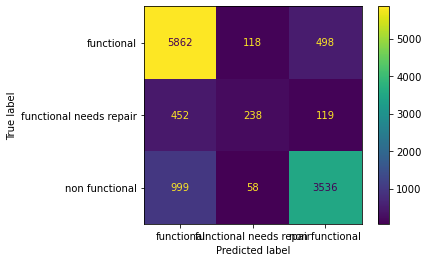

In [38]:
# Plot 3x3 confusion matrix
plot_confusion_matrix(model, X_val, y_val, values_format='.0f')
plt.show()

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [39]:
# Print classification report 
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6478
functional needs repair       0.57      0.29      0.39       809
         non functional       0.85      0.77      0.81      4593

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.68     11880
           weighted avg       0.81      0.81      0.80     11880



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [68]:
X_test_nf = pd.DataFrame(y_val)
X_test_nf['y_pred_proba'] = model.predict_proba(X_val)[:,-1]
X_test_nf = X_test_nf[(X_test_nf['y_pred_proba']>0.95) & (X_test_nf['status_group']=='non functional')]

**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [81]:
X_test_nf = X_test_nf['y_pred_proba'].sort_values(ascending=False).head(100)

# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [91]:
latitude = X_val.loc[X_test_nf.index, 'latitude']
longitude = X_val.loc[X_test_nf.index, 'longitude']

In [92]:
import plotly.express as px
fig = px.scatter(latitude, longitude)
fig.show()